#Video Level data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
print(check_output(["ls", "../input/video_level"]).decode("utf8"))
video_lvl_record = "../input/video_level/train-1.tfrecord"
frame_lvl_record = "../input/frame_level/train-1.tfrecord"
labels_df = pd.read_csv('../input/label_names.csv')

In [ ]:
## Reading video level data in tfrecord format
vid_ids = []
labels = []
mean_rgb = []
mean_audio = []
textual_labels = []
textual_labels_nested = []

label_counts = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)
    vid_ids.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
    label_example = tf_example.features.feature['labels'].int64_list.value
    labels.append(label_example)
    label_counts.append(len(label_example))
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)
    
    label_example_textual = list(labels_df[labels_df['label_id'].isin(list(label_example))]['label_name'])
    textual_labels_nested.append(set(label_example_textual))
    textual_labels = textual_labels + label_example_textual
    
## The size of this tfrecord:
print('Number of videos in this tfrecord: ',len(vid_ids))


### Let's explore the first video 

In [ ]:
## Let's explore the first video 
from collections import Counter
label_mapping = pd.Series.from_csv('../input/label_names.csv',header=0).to_dict()
print('The video id is: %str ' %vid_ids[0]) # https://www.youtube.com/watch?v=-1VnJGJ6c2U
label_names = [label_mapping[x] for x in labels[0]]
print('The labels of this video are: ',label_names )
print('The first video has a vector of %d rgb features' %len(mean_rgb[0]))
print('The first video has a vector of %d audio features' %len(mean_audio[0]))
print('The vector rgb feature (first 10) for this video is: ')
print(mean_rgb[0][:10])
print('The vector audio feature (first 10) for this video is:') 
print(mean_audio[0][:10])


### Let's explore the feature vectors of the first video (rgb and audio vectors)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.title('Audio feature vector')
plt.plot(mean_audio[0][:])

plt.figure(2)
plt.title('Rgb feature vector')
plt.plot(mean_rgb[0][:])

# Frame level data for the first video

In [ ]:
# Reading frame level data for the first video

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    break

## Let's explore the feature vectors of the first video

In [ ]:
print('The first video has %d frames' %len(feat_rgb[0]))
print('The rgb feature vector of the first frame has %d lenght' %len(feat_rgb[0][0]))
print('The audio feature vector of the first frame has %d lenght' %len(feat_audio[0][0]))
print('The first frame has the rgb feature vector:', feat_rgb[0][0])
print('The first frame has the audio feature vector:', feat_audio[0][0])

plt.figure(1)
plt.title('Audio feature vector for the first frame')
plt.plot(feat_audio[0][0])

plt.figure(2)
plt.title('Rgb feature vector for the first frame')
plt.plot(feat_rgb[0][0])


# Vocabulary

In [ ]:
print(labels_df)
print("Nevertheless, we have {} unique labels in the dataset".format(len(labels_df['label_name'].unique())))

****

# Traning data (Only first 1178 videos)

### Label distribution

In [ ]:
sns.distplot(label_counts, kde=False)
plt.title('Number of labels for each video (only first tfrecord, first 1178 videos)')
plt.ylabel('Number of Videos')
plt.xlabel('Number of Labels')

# In this plot we can observe that in the first record we have mostly 1-4 labels describing each video

### Top labels distribution (1 label, 2 labels, 3 labels)

In [ ]:
# define helper function to group data
def grouped_data_for(l):
    # wrap the grouped data into dataframe, since the inner is pd.Series, not what we need
    l_with_c = pd.DataFrame(
        pd.DataFrame({'label': l}).groupby('label').size().rename('n')
    ).sort_values('n', ascending=False).reset_index()
    return l_with_c

In [ ]:
N = 20

textual_labels_with_counts_all = grouped_data_for(textual_labels)

sns.barplot(y='label', x='n', data=textual_labels_with_counts_all.iloc[0:N, :])
plt.title('Top {} labels with number of videos for each label (sample count) '.format(N))

In [ ]:
two_element_labels = ['|'.join(sorted(x)) for x in textual_labels_nested if len(x) == 2]

N = 20

textual_labels_with_counts = grouped_data_for(two_element_labels)

sns.barplot(y='label', x='n', data=textual_labels_with_counts.iloc[0:N, :])
plt.title('Top {} labels with sample count from only samples with two labels'.format(N))

In [ ]:
two_element_labels = ['|'.join(sorted(x)) for x in textual_labels_nested if len(x) == 3]

N = 20

textual_labels_with_counts = grouped_data_for(two_element_labels)

sns.barplot(y='label', x='n', data=textual_labels_with_counts.iloc[0:N, :])
plt.title('Top {} labels with sample count from only samples with three labels'.format(N))

### Correlation between labels in training data

In [23]:
top_50_labels = list(textual_labels_with_counts_all['label'][0:50].values)

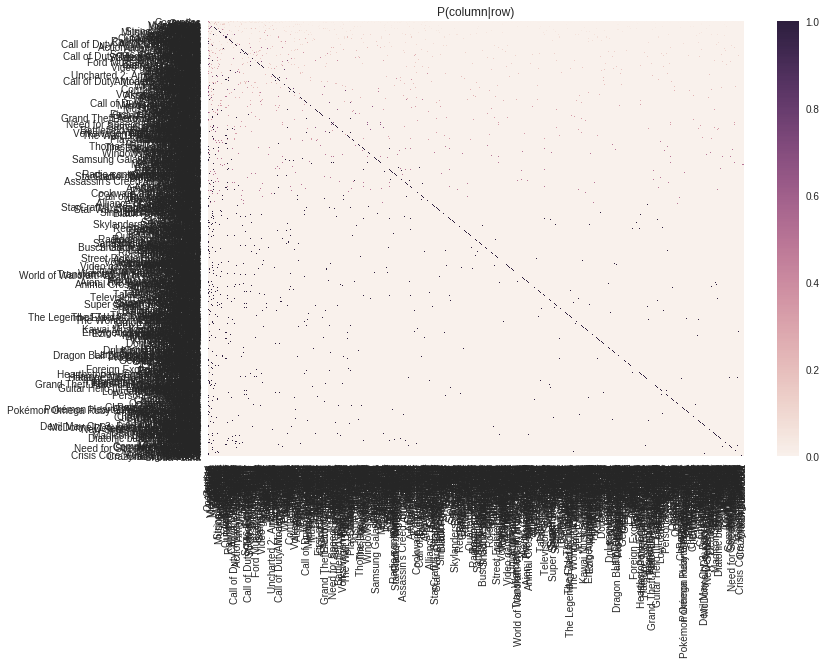

In [22]:
K_labels = []

for i in top_50_labels:
    row = []
    for j in top_50_labels:
        # find all records that have label `i` in them
        i_occurs = [x for x in textual_labels_nested if i in x]
        # how often does j occur in total in them?
        j_and_i_occurs = [x for x in i_occurs if j in x]
        k = 1.0*len(j_and_i_occurs)/len(i_occurs)
        row.append(k)
    K_labels.append(row)

K_labels = np.array(K_labels)
K_labels = pd.DataFrame(K_labels)
K_labels.columns = top_50_labels
K_labels.index = top_50_labels

plt.figure(figsize=(12,8))
sns.heatmap(K_labels)
# probability of observing column label given row label
plt.title('P(column|row)')